In [1]:
%matplotlib inline    
import matplotlib as mplt
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot')

from utils_libs import *
from utils_data_prep import *

from scipy.stats import lognorm
from scipy.stats import norm
from scipy.stats import chisqprob

from numpy import prod
import seaborn as sns

# statiscal models
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import VAR, DynamicVAR

from statsmodels.stats import diagnostic

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

import math

/home/guo/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
http://www.statsmodels.org/stable/examples/index.html#stats
http://www.pyflux.com/docs/garch.html
https://pydlm.github.io/pydlm_user_guide.html#trend

http://sfb649.wiwi.hu-berlin.de/fedc_homepage/xplore/tutorials/xegbohtmlnode37.html

In [ ]:
arima
arima+X

structural
structural+X

Garch
E-Garchs

http://www.chadfulton.com/topics/state_space_python.html
    
http://www.chadfulton.com/topics/markov_autoregression.html
    
http://otexts.org/fpp2/?__utma=1.453539700.1516660050.1516660050.1516660050.1&__utmb=1.2.9.1516660050&__utmc=1&__utmx=-&__utmz=1.1516660050.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none)&__utmv=-&__utmk=67715857


In [4]:
file_postfix = "v_minu_reg"
xtrain = np.load("../dataset/bitcoin/training_data/xtrain_"+file_postfix+".dat")
xtest  = np.load("../dataset/bitcoin/training_data/xtest_" +file_postfix+".dat")
ytrain = np.load("../dataset/bitcoin/training_data/ytrain_"+file_postfix+".dat")
ytest  = np.load("../dataset/bitcoin/training_data/ytest_" +file_postfix+".dat")

In [3]:
from pandas.io.data import DataReader
from datetime import datetime

a = DataReader('AMZN',  'yahoo', datetime(2012,1,1), datetime(2016,6,1))
a_returns = pd.DataFrame(np.diff(np.log(a['Adj Close'].values)))
a_returns.index = a.index.values[1:a.index.values.shape[0]]
a_returns.columns = ["Amazon Returns"]

spy = DataReader('SPY',  'yahoo', datetime(2012,1,1), datetime(2016,6,1))
spy_returns = pd.DataFrame(np.diff(np.log(spy['Adj Close'].values)))
spy_returns.index = spy.index.values[1:spy.index.values.shape[0]]
spy_returns.columns = ['S&P500 Returns']

one_mon = DataReader('DGS1MO', 'fred',datetime(2012,1,1), datetime(2016,6,1))
one_day = np.log(1+one_mon)/365

returns = pd.concat([one_day,a_returns,spy_returns],axis=1).dropna()
excess_m = returns["Amazon Returns"].values - returns['DGS1MO'].values
excess_spy = returns["S&P500 Returns"].values - returns['DGS1MO'].values
final_returns = pd.DataFrame(np.transpose([excess_m,excess_spy, returns['DGS1MO'].values]))
final_returns.columns=["Amazon","SP500","Risk-free rate"]
final_returns.index = returns.index

plt.figure(figsize=(15,5))
plt.title("Excess Returns")
x = plt.plot(final_returns);
plt.legend(iter(x), final_returns.columns);

ImportError: The pandas.io.data module is moved to a separate package (pandas-datareader). After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.

In [8]:
from sklearn import linear_model
bayesian_reg = linear_model.BayesianRidge( normalize=True, fit_intercept=True )
bayesian_reg.fit(xtrain, ytrain)

pytrain = bayesian_reg.predict( xtrain, return_std=True )
print np.shape(pytrain)

(2, 8500)


In [9]:
pytrain[0]

array([ 0.03945083,  0.04555571,  0.03650842, ...,  0.07042467,
        0.0790423 ,  0.0568946 ])

In [29]:
file_postfix = "garch"
vol_train = np.load("../dataset/bitcoin/training_data/voltrain_"+file_postfix+".dat")
rt_train  = np.load("../dataset/bitcoin/training_data/rttrain_" +file_postfix+".dat")
vol_test = np.load("../dataset/bitcoin/training_data/voltest_"+file_postfix+".dat")
rt_test  = np.load("../dataset/bitcoin/training_data/rttest_" +file_postfix+".dat")

In [1]:
import numpy as np
import pyflux as pf
import pandas as pd
# from pandas.io.data import DataReader

from pandas_datareader import data, wb

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

jpm = DataReader('JPM',  'yahoo', datetime(2006,1,1), datetime(2016,3,10))
returns = pd.DataFrame(np.diff(np.log(jpm['Adj Close'].values)))
returns.index = jpm.index.values[1:jpm.index.values.shape[0]]
returns.columns = ['JPM Returns']

plt.figure(figsize=(15,5));
plt.plot(returns.index,returns);
plt.ylabel('Returns');
plt.title('JPM Returns');

NameError: name 'DataReader' is not defined

In [55]:
model = pf.GARCH(rt_train,p=1,q=1)
x = model.fit()
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: 27110.619                         
End Date: 8514                                          AIC: -54213.238                                   
Number of observations: 8514                            BIC: -54185.0402                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0                                                              
q(1)                                 

In [61]:
sigma2, Y, ___ = model._model(model.latent_variables.get_z_values())

tmp = np.asarray(vol_train[1:]-sigma2**0.5)

print mean(tmp*tmp)**0.5

tmp_pre = np.asarray( model.predict(1002) )
res = []
for i in tmp_pre:
    res.append(i[0])

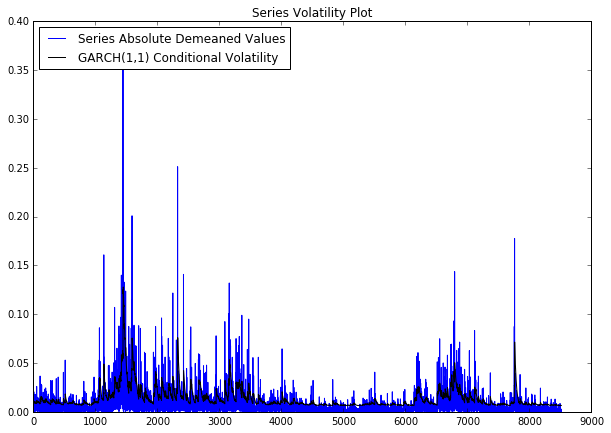

In [84]:
model.plot_fit()

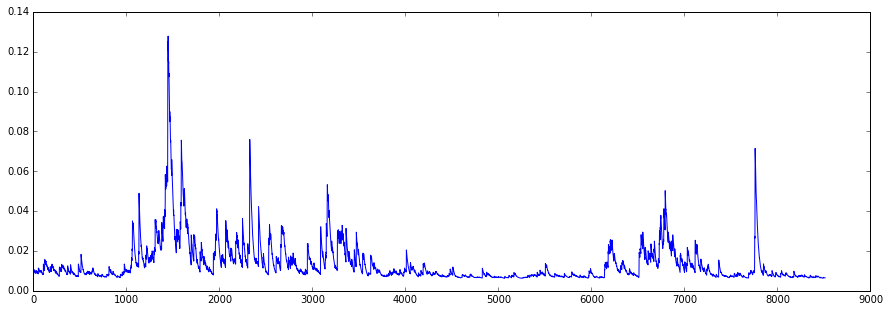

In [83]:

fig, ax = plt.subplots()
fig.set_size_inches( 15,5 )

# ax.plot(vol_train)
ax.plot((sigma2)**0.5)


# lag_corr  = pacf( rt_train, nlags = 48, alpha=0.05 )  

# fig, ax = plt.subplots()
# ax.plot(lag_corr,  marker='o', linestyle='--', label = 'Auto-correlation', color = 'b')()

In [19]:
print model.latent_variables.get_z_names()
print model.latent_variables.get_z_values('v')

['Vol Constant', 'p(1)', 'q(1)', 'v', 'Returns Constant']
[ 0.   3.2 -1.5  2.   0. ]


In [4]:
# --- Load pre-processed training and testing data ---
file_postfix = "stat"
xtrain = np.load("../dataset/bitcoin/training_data/xtrain_"+file_postfix+".dat")
extrain  = np.load("../dataset/bitcoin/training_data/extrain_" +file_postfix+".dat")
xtest = np.load("../dataset/bitcoin/training_data/xtest_"+file_postfix+".dat")
extest  = np.load("../dataset/bitcoin/training_data/extest_" +file_postfix+".dat")

print np.shape(xtrain), np.shape(extrain), np.shape(xtest), np.shape(extest)

(8515,) (8515, 140) (2125,) (2125, 140)


In [1]:
import pyflux as pf

model = pf.EGARCH(returns, p=1, q=1)
x = model.fit()
x.summary()

model.plot_fit(figsize=(15,5))

In [6]:
roll_mod = sm.tsa.statespace.SARIMAX(endog = xtrain, order = (16, 0, 1))
fit_res = roll_mod.fit(disp=False)

predict = fit_res.get_forecast(len(xtest), exog = extest )
predict_ci = predict.conf_int()

/home/guo/.local/lib/python2.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1924: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


In [35]:
# mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order = arima_order )
# res = mod.filter(fit_res.params)

# In-sample one-step-ahead predictions
predict = fit_res.get_prediction(8514, 8515, exog = np.reshape(extrain[10],[1,140]) )
predict_ci = predict.conf_int()
print predict.predicted_mean

[ 0.07943904 -0.15372915]


In [77]:
# rolling fitting and one-step ahead prediction

def roll_prediction_arimax( xtr, extr, xts, exts, training_order, arima_order, bool_add_ex ):
    roll_x = xtr
    roll_ex= extr
    
    exdim = len(exts[0])
    y_hat = []
    
    for i in range(1):
        
        roll_x  = np.concatenate( (roll_x,   xts[i:i+1]) )
        roll_ex = np.concatenate( (roll_ex, exts[i:i+1]) )
        
        tmp_x = roll_x[-training_order:]
        tmp_ex = roll_ex[-training_order:]
        
        if bool_add_ex == True:
            roll_mod = sm.tsa.statespace.SARIMAX(endog = tmp_x, exog = tmp_ex, order = arima_order)
            
            fit_res = roll_mod.fit(disp=False)
            predict = fit_res.get_prediction(len(tmp_x),len(tmp_ex), exog = np.reshape(exts[i], [1, exdim]))
            predict_ci = predict.conf_int()
            
        else:
            roll_mod = sm.tsa.statespace.SARIMAX(endog = tmp_x, order = arima_order)
            
            fit_res = roll_mod.fit(disp=False)
            predict = fit_res.get_prediction(len(tmp_x),len(tmp_ex))
            predict_ci = predict.conf_int()
            
        y_hat.append(predict.predicted_mean)
    
    y_hat = [0]*len(xts)
    # return rooted mse    
    return  y_hat, sqrt(mean((np.asarray(xts) - np.asarray(y_hat))*(np.asarray(xts) - np.asarray(y_hat))))


In [81]:
#Gaussian process model 

%matplotlib inline


class GP(object):

    @classmethod
    def kernel_bell_shape(cls, x, y, delta=1.0):
        return np.exp(-1/2.0 * np.power(x - y, 2) / delta)

    @classmethod
    def kernel_laplacian(cls, x, y, delta=1):
        return np.exp(-1/2.0 * np.abs(x - y) / delta)

    @classmethod
    def generate_kernel(cls, kernel, delta=1):
        def wrapper(*args, **kwargs):
            kwargs.update({"delta": delta})
            return kernel(*args, **kwargs)
        return wrapper

    def __init__(self, x, y, cov_f=None, R=0):
        super().__init__()
        self.x = x
        self.y = y
        self.N = len(self.x)
        self.R = R

        self.sigma = []
        self.mean = []
        self.cov_f = cov_f if cov_f else self.kernel_bell_shape
        self.setup_sigma()

    @classmethod
    def calculate_sigma(cls, x, cov_f, R=0):
        N = len(x)
        sigma = np.ones((N, N))
        for i in range(N):
            for j in range(i+1, N):
                cov = cov_f(x[i], x[j])
                sigma[i][j] = cov
                sigma[j][i] = cov

        sigma = sigma + R * np.eye(N)
        return sigma

    def setup_sigma(self):
        self.sigma = self.calculate_sigma(self.x, self.cov_f, self.R)

    def predict(self, x):
        cov = 1 + self.R * self.cov_f(x, x)
        sigma_1_2 = np.zeros((self.N, 1))
        for i in range(self.N):
            sigma_1_2[i] = self.cov_f(self.x[i], x)

        # SIGMA_1_2 * SIGMA_1_1.I * (Y.T -M)
        # M IS ZERO
        m_expt = (sigma_1_2.T * np.mat(self.sigma).I) * np.mat(self.y).T
        # sigma_expt = cov - (sigma_1_2.T * np.mat(self.sigma).I) * sigma_1_2
        sigma_expt = cov + self.R - (sigma_1_2.T * np.mat(self.sigma).I) * sigma_1_2
        return m_expt, sigma_expt

    @staticmethod
    def get_probability(sigma, y, R):
        multiplier = np.power(np.linalg.det(2 * np.pi * sigma), -0.5)
        return multiplier * np.exp(
            (-0.5) * (np.mat(y) * np.dot(np.mat(sigma).I, y).T))

    def optimize(self, R_list, B_list):

        def cov_f_proxy(delta, f):
            def wrapper(*args, **kwargs):
                kwargs.update({"delta": delta})
                return f(*args, **kwargs)
            return wrapper

        best = (0, 0, 0)
        history = []
        for r in R_list:
            best_beta = (0, 0)
            for b in B_list:
                sigma = gaus.calculate_sigma(self.x, cov_f_proxy(b, self.cov_f), r)
                marginal = b* float(self.get_probability(sigma, self.y, r))
                if marginal > best_beta[0]:
                    best_beta = (marginal, b)
            history.append((best_beta[0], r, best_beta[1]))
        return sorted(history)[-1], np.mat(history)

In [3]:
X = np.linspace(0.1, 9.9, 20)
print X

[ 0.1         0.61578947  1.13157895  1.64736842  2.16315789  2.67894737
  3.19473684  3.71052632  4.22631579  4.74210526  5.25789474  5.77368421
  6.28947368  6.80526316  7.32105263  7.83684211  8.35263158  8.86842105
  9.38421053  9.9       ]



Learned kernel: 4.59**2 * RBF(length_scale=1.53) + 0.00316**2 * RBF(length_scale=6.04e+03) * ExpSineSquared(length_scale=1.88e-05, periodicity=50.7) + RationalQuadratic(alpha=1e-05, length_scale=384) + RBF(length_scale=0.000253) + WhiteKernel(noise_level=1e-05)

Learned noise levels: [-0.021422    0.14897587 -0.27401033 -0.18857932  0.23209249  0.28513065]


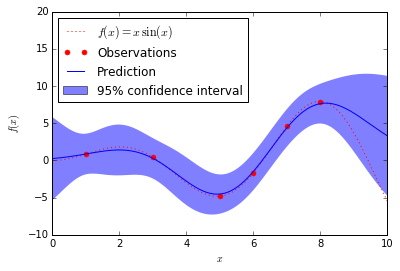

In [40]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *

np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T


# Instanciate a Gaussian Process model
# kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

kernel = 1.0*RBF(length_scale=41.8) + 1.0*RBF(length_scale=180) * ExpSineSquared(length_scale=1.44, periodicity=1) \
+ RationalQuadratic(alpha=17.7, length_scale=0.957) +  RBF(length_scale=0.138) + WhiteKernel(noise_level=0.0336)

alpha_y = np.asarray([0.001]*np.shape(y)[0])

gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=9, alpha = alpha_y, optimizer = 'fmin_l_bfgs_b')

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)


# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)


# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')


# print ' !! parameters:'
# params = gp.get_params()
# for key in sorted(params): print("%s : %s" % (key, params[key]))

print("\nLearned kernel: %s" % gp.kernel_)

print("\nLearned noise levels: %s" % gp.alpha_)


parameters: {'kernel__k2__k2__periodicity_bounds': (1e-05, 100000.0), 'kernel__k2__k2': ExpSineSquared(length_scale=1.44, periodicity=1), 'kernel__k2__k1': RBF(length_scale=180), 'kernel__k1': RBF(length_scale=41.8), 'n_restarts_optimizer': 10, 'kernel__k2__k1__length_scale': 180, 'kernel__k2__k2__length_scale': 1.44, 'kernel': RBF(length_scale=41.8) + RBF(length_scale=180) * ExpSineSquared(length_scale=1.44, periodicity=1), 'kernel__k2__k1__length_scale_bounds': (1e-05, 100000.0), 'copy_X_train': True, 'kernel__k2': RBF(length_scale=180) * ExpSineSquared(length_scale=1.44, periodicity=1), 'random_state': None, 'kernel__k2__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel__k2__k2__periodicity': 1, 'kernel__k1__length_scale': 41.8, 'alpha': array([  8.13238956e-01,   3.98533883e+00,   7.56453723e-02,
         2.36583937e-01,   9.73496378e-01,   2.02318827e+02,
         1.07474308e+00,   4.96028631e+01,   2.64919560e-02,
         3.14641622e-02,   1.11106856e-01,   4.76838219e-01,
  

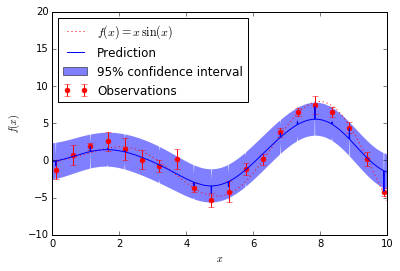

In [27]:
# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instanciate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy / y) ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

print 'parameters:', gp.get_params()


# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

In [33]:
(dy / y) ** 2

array([  8.13238956e-01,   3.98533883e+00,   7.56453723e-02,
         2.36583937e-01,   9.73496378e-01,   2.02318827e+02,
         1.07474308e+00,   4.96028631e+01,   2.64919560e-02,
         3.14641622e-02,   1.11106856e-01,   4.76838219e-01,
         3.44543606e+01,   2.77432996e-02,   6.46036098e-03,
         2.52375022e-02,   1.19036818e-02,   3.00536349e-02,
         3.26795281e+01,   1.73176746e-02])

In [7]:
model = pf.GARCH(np.asarray(return_minu),p=1,q=1)
x = model.fit()
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: 626244.0746                       
End Date: 528515                                        AIC: -1252480.1491                                
Number of observations: 528515                          BIC: -1252435.4378                                
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0                                                              
q(1)                                 

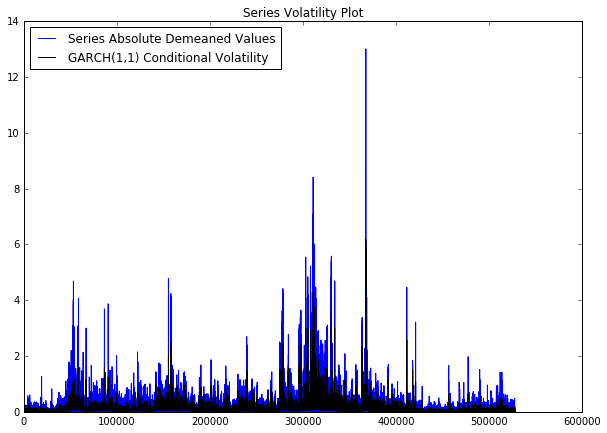

<bound method LatentVariables.get_z_approx_dist of <pyflux.latent_variables.LatentVariables object at 0x7fd99ad42dd0>>


In [14]:
model.plot_fit()

tmp = model.latent_variables
print tmp.get_z_approx_dist

In [31]:
# structural time seris model
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason


data = [0] * 100 + [3] * 100
SP500Index = [[2000] for i in range(100)] + [[2010] for i in range(100)]
page = [[i, i + 1, i + 2, i + 3] for i in range(200)]
myDLM = dlm(data)
myDLM = myDLM + trend(degree=1, discount=0.95, name='trend1')
myDLM = myDLM + seasonality(period=7, discount=0.99, name='week')
myDLM = myDLM + dynamic(features=SP500Index, discount=1, name='SP500')
myDLM = myDLM + dynamic(features=page, discount=1, name='page')

In [ ]:
myDLM.fitForwardFilter()
myDLM.fitBackwardSmoother()
myDLM.fit()

0.110898593803 0.0552157069269


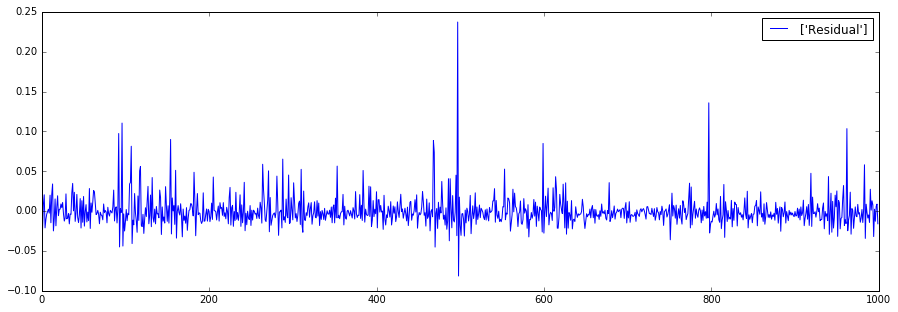

In [51]:
bayesian_reg = linear_model.BayesianRidge( normalize=True, fit_intercept=True )
bayesian_reg.fit(xtrain, ytrain)

# BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
#        fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
#        normalize=False, tol=0.001, verbose=False)

pytrain = bayesian_reg.predict( xtrain )
pytest = bayesian_reg.predict( xtest )
    
tmp_tr = sqrt(sum((pytrain-ytrain)*(pytrain-ytrain))/len(ytrain))
tmp_ts = sqrt(sum((pytest-ytest)*(pytest-ytest))/len(ytest))

print tmp_tr, tmp_ts

pair = np.transpose( np.asarray([pytrain[:1000], ytrain[:1000]]), [1,0])

# fig, ax = plt.subplots()
# fig.set_size_inches( 15,5 )
# ax.plot(pair, label=['Prediction','Truth'])
# ax.legend()

fig, ax = plt.subplots()
fig.set_size_inches( 15,5 )
ax.plot( (ytrain-pytrain)[:1000], label=['Residual'])
ax.legend()

In [86]:
# ---- Load pre-processed training and testing data ----

#file_postfix = "mle_norm_mix"
file_postfix = "norm_vmin_mix"

xtrain = np.load("../dataset/bitcoin/training_data/xtrain_"+file_postfix+".dat")
xtest  = np.load("../dataset/bitcoin/training_data/xtest_" +file_postfix+".dat")
ytrain = np.load("../dataset/bitcoin/training_data/ytrain_"+file_postfix+".dat")
ytest  = np.load("../dataset/bitcoin/training_data/ytest_" +file_postfix+".dat")

print np.shape(xtrain), np.shape(ytrain), np.shape(xtest), np.shape(ytest)

# split training and testing data into three feature groups      
xtr_v =   np.asarray( [i[0] for i in xtrain] )
xtr_req = np.asarray( [i[1] for i in xtrain] )
xtr_distr = np.asarray( [i[2] for i in xtrain] )

xts_v =   np.asarray( [i[0] for i in xtest] )
xts_req = np.asarray( [i[1] for i in xtest] )
xts_distr = np.asarray( [i[2] for i in xtest] )

# !! IMPORTANT: feature normalization

xts_v = conti_normalization_test_dta(  xts_v, xtr_v )
xtr_v = conti_normalization_train_dta( xtr_v )

xts_req = conti_normalization_test_dta(  xts_req, xtr_req )
xtr_req = conti_normalization_train_dta( xtr_req )

xts_distr = conti_normalization_test_dta(  xts_distr, xtr_distr )
xtr_distr = conti_normalization_train_dta( xtr_distr )

print np.shape(xtr_v), np.shape(xtr_req), np.shape(xtr_distr)
print np.shape(xts_v), np.shape(xts_req), np.shape(xts_distr)

(8500, 3) (8500,) (2125, 3) (2125,)
(8500, 16) (8500, 20) (8500, 20)
(2125, 16) (2125, 20) (2125, 20)


[ 0.00246143 -0.03314781 -0.00256457 ...,  0.00342681 -0.03413856
 -0.03624272]


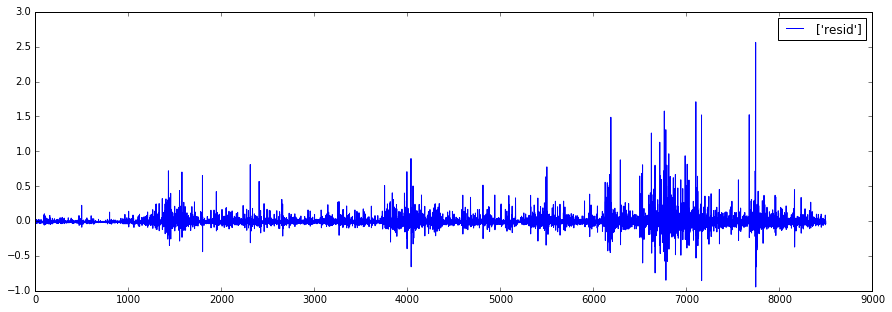

In [477]:
bayesian_reg = linear_model.BayesianRidge( normalize=True, fit_intercept=True )
bayesian_reg.fit(xtr_v, ytrain)

# BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
#        fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
#        normalize=False, tol=0.001, verbose=False)

pytrain = bayesian_reg.predict( xtr_v )

resid = ytrain - pytrain
print resid

fig, ax = plt.subplots()
fig.set_size_inches( 15,5 )
ax.plot( resid, label=['resid'])
ax.legend()

In [450]:
reg = linear_model.BayesianRidge( normalize=True, fit_intercept=True )
reg.fit(xtr_distr, resid)

# BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
#        fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
#        normalize=False, tol=0.001, verbose=False)
resid_hat = reg.predict( xtr_distr )

In [478]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=0.001, fit_intercept = True, normalize= True)
reg.fit(xtr_distr,resid) 

resid_hat = reg.predict( xtr_distr )
# pytrain = clf.predict( xtrain )
# pytest = clf.predict( xtest )

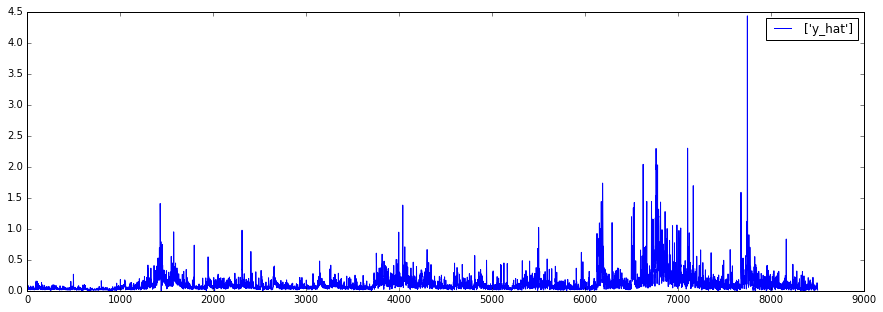

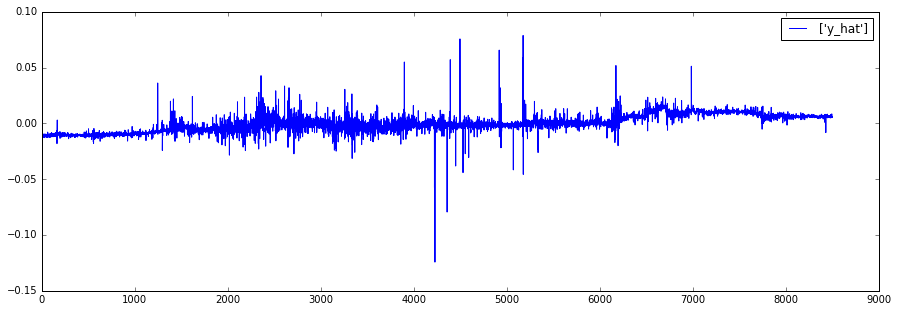

In [479]:
resid_hat = reg.predict( xtr_distr )

fig, ax = plt.subplots()
fig.set_size_inches( 15,5 )
ax.plot( ytrain, label=['y_hat'])
ax.legend()

fig, ax = plt.subplots()
fig.set_size_inches( 15,5 )
ax.plot( resid_hat, label=['y_hat'])
ax.legend()


In [80]:
# from regression_models import *

# # --- model and training log set-up ---
# result_file = "res/norm_v_minu_reg.txt"
# # test and training errors 

# model_file = "model/norm_v_minu_reg"
# bool_clf = False

# reg = gbt_train_validate(xtr_distr, resid, [], [] , 0.0, bool_clf, result_file, model_file + '_gbt.sav')

In [480]:
y_hat = bayesian_reg.predict( xtr_v ) + reg.predict( xtr_distr )

resid = ytrain - y_hat
print  sqrt(mean(resid*resid))

0.111203246942


In [74]:
reg.predict( xtr_distr )

array([-0.01083692, -0.01052454, -0.0103918 , ...,  0.00629497,
        0.005763  ,  0.00614485])

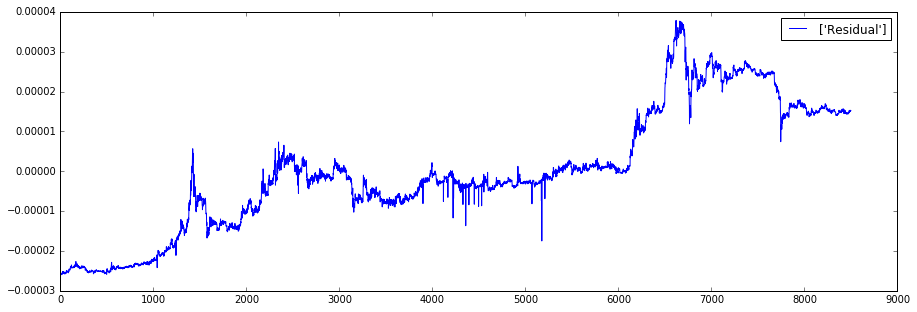

In [374]:
y_hat = bayesian_reg.predict( xtr_v ) + reg.predict( xtr_distr )
resid = ytrain - y_hat

fig, ax = plt.subplots()
fig.set_size_inches( 15,5 )
ax.plot( resid_hat[:], label=['Residual'])
ax.legend()

In [481]:
y_hat = bayesian_reg.predict( xts_v ) + reg.predict( xts_distr )

resid = ytest - y_hat
print  sqrt(mean(resid*resid))

0.0527581176378


In [471]:
reg.predict( xts_distr )[:2000]

array([ 0.00056941,  0.00056993,  0.00056513, ...,  0.00124944,
        0.00124682,  0.00124364])

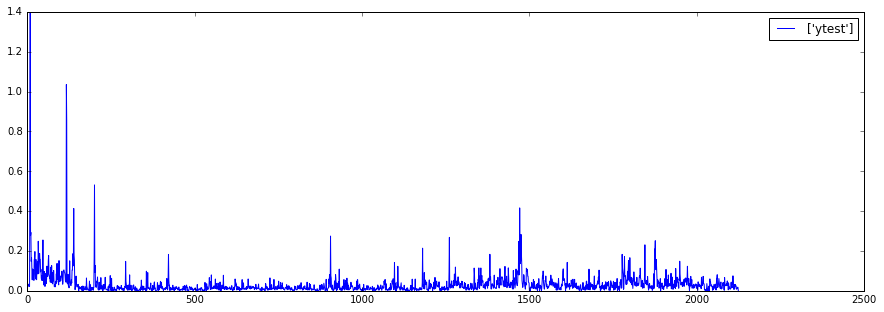

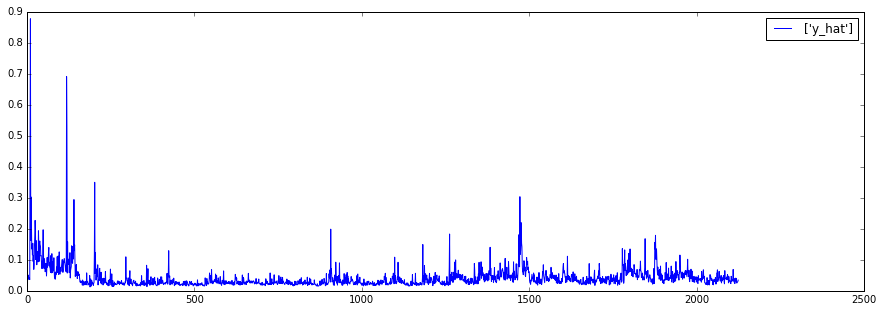

In [421]:
fig, ax = plt.subplots()
fig.set_size_inches( 15,5 )
ax.plot( ytest, label=['ytest'])
ax.legend()

fig, ax = plt.subplots()
fig.set_size_inches( 15,5 )
ax.plot( y_hat, label=['y_hat'])
ax.legend()